In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pbdlib as pbd
import scipy as sp

### Load some data

In [2]:
data = scipy.io.loadmat('2Dletters/A.mat')

In [3]:
# Make a list with all demonstrations
demos = []
for data_demo in data.get('demos')[0]:
    demos.append(data_demo[0,0][0])
    
# Add a time input
for i in range(0,len(demos)):
    t = np.linspace(0,1,demos[i].shape[1])
    demos[i] = np.vstack((t,demos[i]))

(-8.495425491012577, 7.427876379404074, -8.796731212046042, 6.680432716454869)

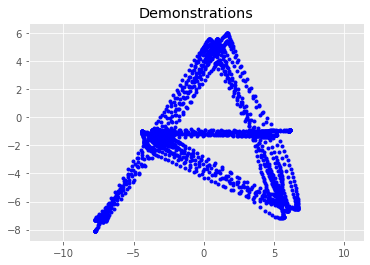

In [4]:
plt.figure
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'b.')
plt.title('Demonstrations')
plt.axis('equal')
#plt.axis('tight')

### Define basis functions

In [5]:
def rbf(x1,x2,h=1E-2):
    return np.exp(-(0.5/h)*np.dot(x1-x2,x1-x2))

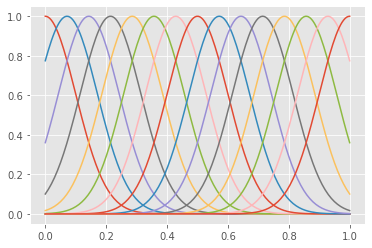

In [6]:
nb = 15
c = np.linspace(0,1,nb)     # centers of basis functions

q = np.zeros((t.shape[0],nb))
for i in range(0,t.shape[0]):
    for j in range(0,nb):
        q[i,j] = rbf(t[i],c[j])      

plt.figure
plt.plot(t,q)

### Compute weights

In [7]:
#lambd = 1E-8
lambd = 0
w = np.zeros((len(demos),2*nb))

n_w = 0
for demo in demos:
    
    x = demo[1:3,:]
    x = x.T.reshape(-1,1)
    phi = np.zeros(nb)
    Phi_tmp = np.zeros((2,2*nb,demo.shape[1]))
    for k in range(0,demo.shape[1]):
        for j in range(0, nb):
            phi[j] = rbf(demo[0,k],c[j])
        Phi_tmp[:,:,k] = np.kron(np.eye(2) ,phi)
    #Phi = np.zeros((2*demo.shape[1],2*nb))
    Phi = np.zeros((2*demo.shape[1],2*nb))
    for i in range(0,demo.shape[1]):
    #    Phi[2*i:2*i+2,(2*nb*i):2*nb*(i+1)]=Phi_tmp[:,:,i]
        Phi[2*i:2*i+2,:]=Phi_tmp[:,:,i]
    w[n_w,:] = np.dot(np.linalg.inv(np.dot(Phi.T,Phi)+lambd*np.eye(Phi.shape[1])),np.dot(Phi.T,x)).reshape(2*nb)
    n_w+=1

### Regression

In [8]:
# Compute weight distribution
u_w = np.mean(w,0)
cov_w = np.cov(w.T)

In [9]:
# Compute Phi for new inputs
t = np.linspace(0,1,100)
n_test = t.shape[0]
Phi_tmp = np.zeros((2,2*nb,n_test))

for k in range(0,t.shape[0]):
    for j in range(0, nb):
        phi[j] = rbf(t[k],c[j])
    Phi_tmp[:,:,k] = np.kron(np.eye(2),phi)

Phi = np.zeros((2*n_test,2*nb))
for i in range(0,n_test):
    Phi[2*i:2*i+2,:]=Phi_tmp[:,:,i]
    
x_new_vec = np.dot(Phi,u_w)
x_new = np.array([np.dot(Phi,u_w)[0::2],np.dot(Phi,u_w)[1::2]]) # put the 2 rows in a list and make an ndarray

Sigma = np.dot(np.dot(Phi,cov_w),Phi.T)


(-8.495425491012577, 7.427876379404074, -8.799582988452885, 6.740320020998559)

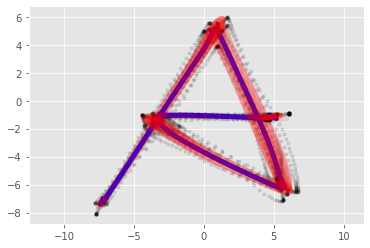

In [10]:
# Plot generated trajectory
plt.figure
plt.plot(x_new[0,:],x_new[1,:])
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'k.',alpha=0.1)
    
plt.plot(x_new[0,:],x_new[1,:],'b',linewidth=5.0)

for i in range(0,n_test,1):
    pbd.plot_gmm([x_new[0,i],x_new[1,i]],Sigma[2*i:2*i+2,2*i:2*i+2],alpha=0.1)

plt.axis('equal')

### Via-points

In [11]:
# t_new = 0.75
# y_new = np.array([10,0])
# Sigma_new = 1E-8*np.eye(2)
# Phi_via = np.zeros((2,2*nb))

# # updated weights
# for j in range(0, nb):
#     phi[j] = rbf(t_new,c[j])
    
# Phi_via[0:2,:]=np.kron(np.eye(2),phi)
# u_new = u_w + cov_w.dot(Phi_via.T).dot(np.linalg.inv(Sigma_new + Phi_via.dot(cov_w).dot(Phi_via.T))).dot(y_new-Phi_via.dot(u_w))
# Sigma_new = cov_w + cov_w.dot(Phi_via.T).dot(np.linalg.inv(Sigma_new + Phi_via.dot(cov_w).dot(Phi_via.T))).dot(Phi_via.dot(u_w))

# # compute new trajectory distribution
# x_new = np.array([np.dot(Phi,u_new)[0::2],np.dot(Phi,u_new)[1::2]]) # put the 2 rows in a list and make an ndarray
# Sigma = np.dot(np.dot(Phi,Sigma_new),Phi.T)


In [12]:
# # Plot new trajectory distribution
# plt.figure
# plt.plot(x_new[0,:],x_new[1,:])
# for i in range(0,len(demos)):
#     plt.plot(demos[i][1,:],demos[i][2,:],'k.',alpha=0.1)
# plt.plot(x_new[0,:],x_new[1,:],'b',linewidth=5.0)

# #for i in range(0,n_test,10):
# #    pbd.plot_gmm([x_new[0,i],x_new[1,i]],Sigma[2*i:2*i+2,2*i:2*i+2],alpha=0.1)

# plt.axis('equal')

### Sampling from weight distribution

(-8.501040742254466, 7.545796655483752, -8.823399946122253, 7.2404761320552655)

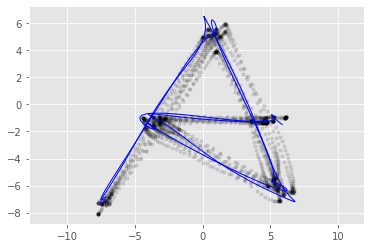

In [13]:
Phi_ = Phi
x_test_ = np.zeros((2,n_test,100))
for n in range(0,100):
    w_test = np.random.multivariate_normal(u_w,cov_w)
    x_test_[:,:,n] = np.array([np.dot(Phi_,w_test)[0::2],np.dot(Phi_,w_test)[1::2]]) # put the 2 rows in a list and make an ndarray

# x_test[:,:,10].T

#Plot sampled trajectories
plt.figure
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'k.',alpha=0.1)
for n in range(0,2):    
    plt.plot(x_test_[0,:,n],x_test_[1,:,n],'b',linewidth=1.0)
plt.axis('equal')

### Sampling from trajectory distribution

/idiap/home/sshetty/anaconda3/envs/pyML/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


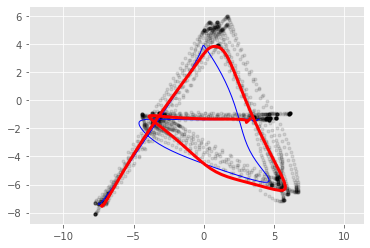

In [14]:
x_test_vec_sampled = np.zeros((2*n_test,100))
x_test = np.zeros((2,n_test,100))
for n in range(0,2):
    x_test_vec_sampled[:,n] = np.random.multivariate_normal(x_new_vec,Sigma)
    #print x_test_vec.shape
    #x_test[:,:,n] = np.array([x_test_vec[0::2,n],x_test_vec[1::2,n]]) # put the 2 rows in a list and make an ndarray

# Plot sampled trajectories
plt.figure
for i in range(0,len(demos)):
    plt.plot(demos[i][1,:],demos[i][2,:],'k.',alpha=0.1)
for n in range(0,1):    
    plt.plot(x_test_vec_sampled[0::2,n],x_test_vec_sampled[1::2,n],'b',linewidth=1.0)

plt.axis('equal')
z  = np.random.randn(200)
x_sample = x_new_vec + sp.linalg.sqrtm(Sigma).dot(z)
plt.plot(x_sample[0::2],x_sample[1::2],'r',linewidth=3.0)

## Tensor Normal Distribution

In [15]:
N1 = 2
N2 = len(demos[0][0,:])
N = len(demos)
#Or
# N1, N2, N = x_test.shape
print(N,N1,N2)

tensor_data = [np.empty([N1,N2])]*N
for i in range(N):
    tensor_data[i] =demos[i][1:,:] # x_test[:,:,i] #
#     if N==3:
#         tmp =tensor_data[i][:,:]
#         tensor_data[i][0:2,:] = tensor_data[i][1:,:]
#         tensor_data[i][2,:] = tmp[0,:] 
        
print("Number of demonstrations: ", len(tensor_data))
print("Shape of each tensor data: ", tensor_data[0].shape)

10 2 200
Number of demonstrations:  10
Shape of each tensor data:  (2, 200)


In [17]:
from tensor_tools import array3
t_tools = array3()
Nb = 5#Number of basis functions
M, Cov, A, Uw, Phi = t_tools.anormal2D(tensor_data,Nb,rbf = True)
print(Cov[0])
print(Cov[1])

Error EM:  401.4258477065689
Error EM:  468.82948525220945
Error EM:  3.578167719723097e-05
Error EM:  3.359804736303241e-09
Error EM:  2.007819495740096e-09
Error EM:  1.5610716285208039e-09
Error EM:  1.1871922487865194e-09
Error EM:  8.175570540787804e-10
Error EM:  1.903746765847141e-09
Error EM:  4.549520691242389e-09
MLE has converged in  9  steps
[[ 1.         -0.55717096]
 [-0.55717096  1.58174099]]
[[1.42733436 1.43418362 1.43970412 ... 0.1862653  0.18306606 0.17983092]
 [1.43418362 1.44129764 1.4470593  ... 0.19572767 0.19258834 0.18939852]
 [1.43970412 1.4470593  1.45310052 ... 0.20553639 0.20246459 0.19932686]
 ...
 [0.1862653  0.19572767 0.20553639 ... 0.72671966 0.73400852 0.74003386]
 [0.18306606 0.19258834 0.20246459 ... 0.73400852 0.74147267 0.7476257 ]
 [0.17983092 0.18939852 0.19932686 ... 0.74003386 0.7476257  0.75392133]]


Text(0.5, 1.0, 'Data Trajectory')

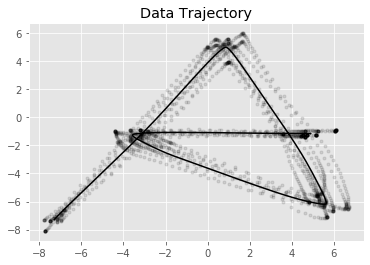

In [26]:
# Plot sampled trajectories
plt.figure
for i in range(0,N):
    plt.plot(tensor_data[i][0,:],tensor_data[i][1,:],'k.',alpha=0.1)
plt.plot(M[0,:],M[1,:],'k')
plt.title("Data Trajectory")

Text(0.5, 1.0, 'Model Distribution and Sampling')

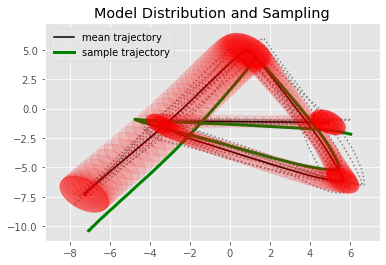

In [27]:
# Generate Trajectories: Sample from the distribution
p = 1
X_ = [None]*p
Cov_ = Cov[:]
Cov_[0] = 0.5*Cov[0]
Cov_[1] = 0.5*Cov[1]
for i in range(p):
    X_[i] = t_tools.anormal_sampling_2D(M,Cov)
   # print(X_[i].shape)

plt.figure
for i in range(0,len(tensor_data)):
    plt.plot(tensor_data[i][0,:],tensor_data[i][1,:],color = [0.5,0.5,0.5], linestyle = ":")
    
plt.plot(M[0,:],M[1,:], 'k', label="mean trajectory")

for i in range(0,N2,1):
    pbd.plot_gmm([M[0,i],M[1,i]], Cov[1][i,i]*Cov[0],alpha=0.1)
    
for i in range(p):
    plt.plot(X_[i][0,:],X_[i][1,:], 'g', linewidth = 3, label = "sample trajectory")
# plt.title('Demonstrations')
# plt.axis('equal')
plt.legend()
plt.title("Model Distribution and Sampling")
#plt.axis('tight')

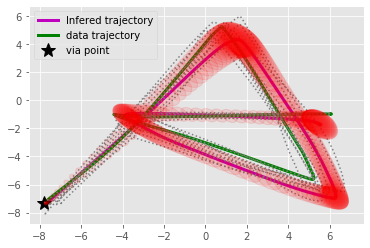

In [38]:

plt.figure
p = np.random.randint(N)
X = tensor_data[p]

k = 0 # via point index
Ia = [k]
X_a = X[:,Ia].reshape(2,len(Ia)) 
M_o, Cov_o, _, _ = t_tools.anormal_condition_2D(M,Cov,Ia,X_a)
M_oo = M[:,:]
Ib = list(set(range(M.shape[1]))- set(Ia))
M_oo[:,Ib] = M_o
M_oo[:,Ia] = X_a
plt.plot(M_oo[0,:],M_oo[1,:], 'm',linewidth=3, label = "Infered trajectory")
plt.plot(X[0,:],X[1,:], 'g', linewidth= 3, label = "data trajectory")
plt.plot(X_a[0],X_a[1], 'k*', markersize=15, label = "via point")

for i in range(0,len(tensor_data)):
    plt.plot(tensor_data[i][0,:],tensor_data[i][1,:],color = [0.5,0.5,0.5], linestyle=':')
for i in range(0,N2-2,1):
    pbd.plot_gmm([M_o[0,i],M_o[1,i]], Cov_o[1][i,i]*Cov_o[0],alpha=0.1)
plt.legend()

## Mixture Modeling of Matrix Normal Distribution